In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sms
import statsmodels.api as sm

pd.set_option('display.max_rows',60000)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',200)
pd.options.display.float_format = '{:,.10f}'.format
import warnings
warnings.filterwarnings("ignore")

# Black Litterman Implementation 

In [3]:
d1 = pd.read_csv('outputs/my_data_view_1_0307.csv')\
[['name','last_actual_date','real_price','cum_return_40d','return_price_40d']].copy()
d1['perc_'] = d1['cum_return_40d'] - 1.0

d2 = pd.read_csv('mini_portfolios_0219.csv')[['Ticker','Sector','Beta','Sector_Weight']].copy()

d3 = pd.merge(d1,d2,how='outer',left_on='name',right_on='Ticker')

d3_output = d3[['Ticker','perc_','Sector','Sector_Weight','Beta']].copy()
#d3_output.to_csv('for_blacklitter.csv')

In [6]:
#assume 'for_blacklitter.csv' looks like this
print(d3_output.head())

  Ticker         perc_              Sector  Sector_Weight         Beta
0   AAPL  0.0205466186          Technology   0.3438944279 1.2000000000
1   AMZN  0.0091908477   Consumer Cyclical   0.5361122685 1.1560000000
2    AZO -0.0823759805   Consumer Cyclical   0.0144500877 0.7030000000
3    BAC  0.1710064722  Financial Services   0.1268331678 1.3420000000
4   BKNG -0.1330972755   Consumer Cyclical   0.0430238002 1.3920000000


In [7]:
ext = pd.read_csv('dataset_250222_run.csv', parse_dates=['date'])[['date','ticker_id','sector','close']].copy()

# Set cutoff date
cutoff_date = pd.to_datetime('2024-10-04')

# Filter data to only include dates up to the cutoff
ext = ext[ext['date'] <= cutoff_date]

# Create an empty list to hold each stock's column
price_columns = []

# Loop through each unique ticker
for ticker in ext['ticker_id'].unique():
    stock_df = ext[ext['ticker_id'] == ticker].sort_values('date', ascending=False).head(200)
    
    # Sort prices in ascending order (oldest to newest)
    stock_prices = stock_df.sort_values('date')['close'].reset_index(drop=True)
    
    # Rename the column to the ticker
    stock_prices.name = ticker
    
    # Append to list
    price_columns.append(stock_prices)

# Concatenate all columns side by side
final_df = pd.concat(price_columns, axis=1)

In [20]:
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
import matplotlib.pyplot as plt



def optimize_stock_portfolio(risk_level: str):
    """
    Run a Black-Litterman optimization at the stock level.

    Parameters:
    - risk_level: 'very low', 'low', 'mid', 'high', or 'very high'

    Returns:
    - Dictionary of optimized stock weights
    """
    # Load CSV
    df = pd.read_csv("for_blacklitter.csv")

    # Use perc_ as absolute return views
    df["perc_"] = df["perc_"].astype(float)
    stock_views = dict(zip(df["Ticker"], df["perc_"]))
    tickers = df["Ticker"].tolist()

    # Simulated or preloaded price data (final_df assumed to be available)
    price_data = final_df[tickers]

    # Compute historical returns and covariance matrix
    mu = mean_historical_return(price_data)
    S = CovarianceShrinkage(price_data).ledoit_wolf()

    # Market caps (can use beta as proxy, or assume equal)
    df["Beta"] = df["Beta"].astype(float)
    market_caps = df.set_index("Ticker")["Beta"]
    market_caps = market_caps / market_caps.sum() * 100  # normalize

    # Market-implied prior returns
    delta = 2.5
    market_prior = market_implied_prior_returns(
        market_caps=market_caps, cov_matrix=S, risk_aversion=delta
    )

    # Black-Litterman model
    bl = BlackLittermanModel(S, pi=market_prior, absolute_views=stock_views)
    bl_returns = bl.bl_returns()
    bl_cov = bl.bl_cov()

    # Efficient frontier optimization
    ef = EfficientFrontier(bl_returns, bl_cov)

    plotting.plot_efficient_frontier(ef)
    plt.show()

    min_ret = bl_returns.min()
    max_ret = bl_returns.max() - 1e-6
    ret_targets = np.linspace(min_ret, max_ret, 5)
    very_low_ret, low_ret, mid_ret, high_ret, very_high_ret = ret_targets

    risk_level = risk_level.lower()
    if risk_level == "very high":
        weights = ef.efficient_return(target_return=very_high_ret)
    elif risk_level == "high":
        weights = ef.efficient_return(target_return=high_ret)
    elif risk_level == "mid":
        weights = ef.efficient_return(target_return=mid_ret)
    elif risk_level == "low":
        weights = ef.efficient_return(target_return=low_ret)
    elif risk_level == "very low":
        weights = ef.efficient_return(target_return=very_low_ret)
    else:
        raise ValueError("Invalid risk level. Choose: very low, low, mid, high, very high.")

    cleaned_weights = ef.clean_weights()
    ef.portfolio_performance(verbose=True)
    return cleaned_weights

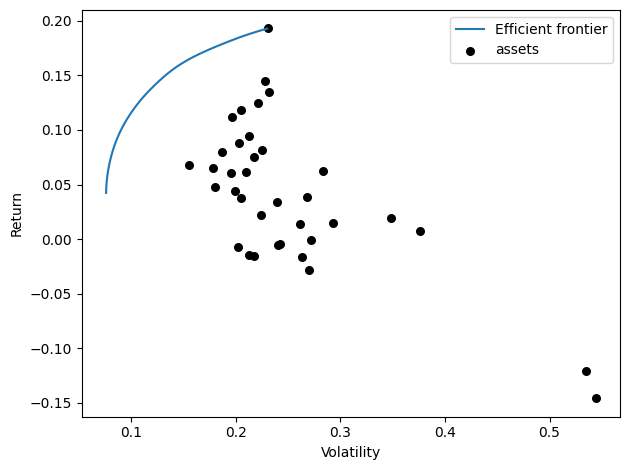

Expected annual return: 19.3%
Annual volatility: 23.0%
Sharpe Ratio: 0.84


OrderedDict([('AAPL', 0.0),
             ('AMZN', 0.0),
             ('AZO', 0.0),
             ('BAC', 0.0),
             ('BKNG', 0.0),
             ('BRK-B', 0.0),
             ('BSX', 0.0),
             ('CB', 0.0),
             ('COP', 0.0),
             ('CRM', 0.0),
             ('CTRA', 0.0),
             ('CVX', 0.0),
             ('DIS', 0.0),
             ('EOG', 0.0),
             ('GOOG', 0.0),
             ('GS', 0.00119),
             ('HCA', 0.9991),
             ('HD', 0.0),
             ('IBM', 0.0),
             ('ISRG', 0.0),
             ('JPM', 0.0),
             ('LLY', 0.0),
             ('MCD', 0.0),
             ('META', 0.0),
             ('MSFT', 0.0),
             ('NFLX', 0.0),
             ('NVDA', 0.0),
             ('OKE', 0.0),
             ('PGR', 0.0),
             ('SYK', 0.0),
             ('T', 0.0),
             ('TSLA', 0.0),
             ('TYL', 0.0),
             ('UNH', 0.0),
             ('VZ', 0.0),
             ('XOM', 0.0)])

In [21]:
optimize_stock_portfolio( risk_level="very high")

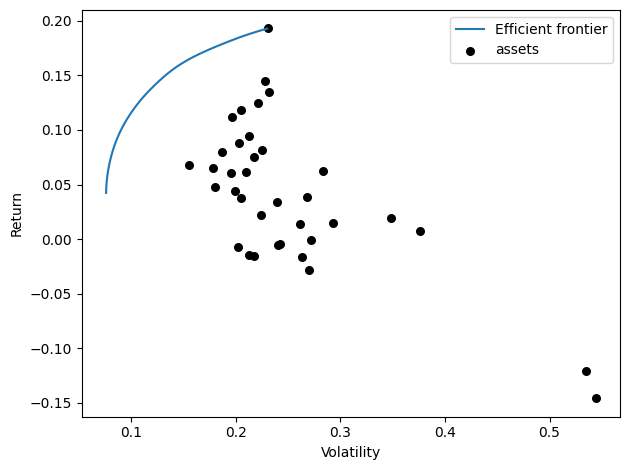

Expected annual return: 10.8%
Annual volatility: 9.5%
Sharpe Ratio: 1.14


OrderedDict([('AAPL', 0.0),
             ('AMZN', 0.0),
             ('AZO', 0.0),
             ('BAC', 0.01207),
             ('BKNG', 0.0),
             ('BRK-B', 0.0),
             ('BSX', 0.10881),
             ('CB', 0.01902),
             ('COP', 0.0145),
             ('CRM', 0.0),
             ('CTRA', 0.0),
             ('CVX', 0.0),
             ('DIS', 0.0),
             ('EOG', 0.03817),
             ('GOOG', 0.01902),
             ('GS', 0.08137),
             ('HCA', 0.17618),
             ('HD', 0.0),
             ('IBM', 0.06916),
             ('ISRG', 0.0),
             ('JPM', 0.0),
             ('LLY', 0.0),
             ('MCD', 0.08889),
             ('META', 0.0),
             ('MSFT', 0.0),
             ('NFLX', 0.0383),
             ('NVDA', 0.0),
             ('OKE', 0.05612),
             ('PGR', 0.14787),
             ('SYK', 0.0),
             ('T', 0.04077),
             ('TSLA', 0.0),
             ('TYL', 0.0),
             ('UNH', 0.07177),
             ('V

In [22]:
optimize_stock_portfolio( risk_level="high")

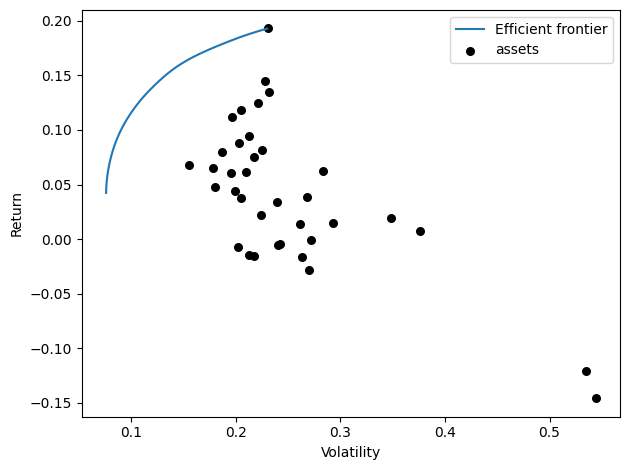

Expected annual return: 4.2%
Annual volatility: 7.6%
Sharpe Ratio: 0.56


OrderedDict([('AAPL', 0.05346),
             ('AMZN', 0.00379),
             ('AZO', 0.06361),
             ('BAC', 0.0),
             ('BKNG', 0.0),
             ('BRK-B', 0.0),
             ('BSX', 0.10643),
             ('CB', 0.095),
             ('COP', 0.02802),
             ('CRM', 0.0),
             ('CTRA', 0.0),
             ('CVX', 0.0),
             ('DIS', 0.03364),
             ('EOG', 0.03004),
             ('GOOG', 0.01684),
             ('GS', 0.0),
             ('HCA', 0.02015),
             ('HD', 0.0),
             ('IBM', 0.0),
             ('ISRG', 0.00974),
             ('JPM', 0.0),
             ('LLY', 0.02487),
             ('MCD', 0.04669),
             ('META', 0.0),
             ('MSFT', 0.0552),
             ('NFLX', 0.01601),
             ('NVDA', 0.00808),
             ('OKE', 0.0),
             ('PGR', 0.07312),
             ('SYK', 0.02687),
             ('T', 0.09901),
             ('TSLA', 0.0),
             ('TYL', 0.03923),
             ('UNH', 0.0

In [23]:
optimize_stock_portfolio( risk_level="mid")

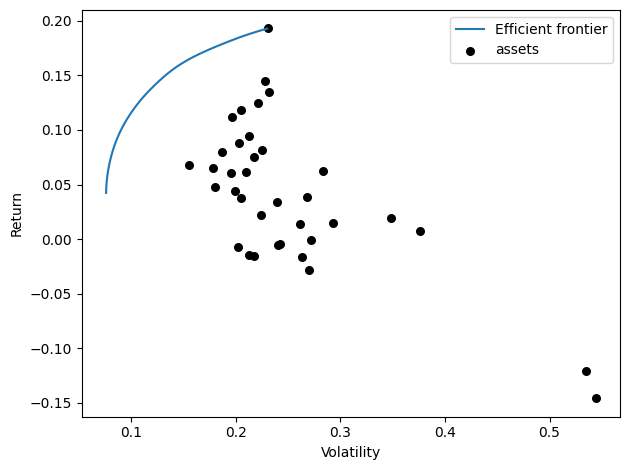

Expected annual return: 4.2%
Annual volatility: 7.6%
Sharpe Ratio: 0.56


OrderedDict([('AAPL', 0.05346),
             ('AMZN', 0.00379),
             ('AZO', 0.06361),
             ('BAC', 0.0),
             ('BKNG', 0.0),
             ('BRK-B', 0.0),
             ('BSX', 0.10643),
             ('CB', 0.095),
             ('COP', 0.02802),
             ('CRM', 0.0),
             ('CTRA', 0.0),
             ('CVX', 0.0),
             ('DIS', 0.03364),
             ('EOG', 0.03004),
             ('GOOG', 0.01684),
             ('GS', 0.0),
             ('HCA', 0.02015),
             ('HD', 0.0),
             ('IBM', 0.0),
             ('ISRG', 0.00974),
             ('JPM', 0.0),
             ('LLY', 0.02487),
             ('MCD', 0.04669),
             ('META', 0.0),
             ('MSFT', 0.0552),
             ('NFLX', 0.01601),
             ('NVDA', 0.00808),
             ('OKE', 0.0),
             ('PGR', 0.07312),
             ('SYK', 0.02687),
             ('T', 0.09901),
             ('TSLA', 0.0),
             ('TYL', 0.03923),
             ('UNH', 0.0

In [24]:
optimize_stock_portfolio( risk_level="low")

In [19]:
optimize_stock_portfolio( risk_level="very low")

Expected annual return: 4.2%
Annual volatility: 7.6%
Sharpe Ratio: 0.56


OrderedDict([('AAPL', 0.05345),
             ('AMZN', 0.00379),
             ('AZO', 0.06361),
             ('BAC', 0.0),
             ('BKNG', 0.0),
             ('BRK-B', 0.0),
             ('BSX', 0.10642),
             ('CB', 0.095),
             ('COP', 0.02802),
             ('CRM', 0.0),
             ('CTRA', 0.0),
             ('CVX', 0.0),
             ('DIS', 0.03363),
             ('EOG', 0.03003),
             ('GOOG', 0.01684),
             ('GS', 0.0),
             ('HCA', 0.02015),
             ('HD', 0.0),
             ('IBM', 0.0),
             ('ISRG', 0.00975),
             ('JPM', 0.0),
             ('LLY', 0.02487),
             ('MCD', 0.04669),
             ('META', 0.0),
             ('MSFT', 0.0552),
             ('NFLX', 0.01601),
             ('NVDA', 0.00808),
             ('OKE', 0.0),
             ('PGR', 0.07312),
             ('SYK', 0.02687),
             ('T', 0.09901),
             ('TSLA', 0.0),
             ('TYL', 0.03922),
             ('UNH', 0.0